### Notebook to genereate boxplots for ddt(CWV) binned by cloud classification scheme.

Assumes output is in a single netcdf file on pressure levels.

James Ruppert  
jruppert@ou.edu  
12/15/23

In [7]:
import numpy as np
import matplotlib
from matplotlib import ticker
import matplotlib.pyplot as plt
import sys
from thermo_functions import *
from precip_class import *
import seaborn as sns
import xarray as xr
from memory_usage import *
from read_functions import *

#### Main settings

In [8]:
# Number of sample time steps
nt=200 # will be chopped down to max available
nt=24

#### Additional settings and directories

In [9]:
storm = 'haiyan'
# storm = 'maria'

# main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/"
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"
figdir = "/home/jamesrup/figures/tc/ens/"+storm+'/'
datdir2 = 'post/d02/'

# Tests to read and compare
# tests = ['crfon','ncrf']
# if storm == 'haiyan':
#     tests = ['ctl','ncrf36h']
# elif storm == 'maria':
#     # tests = ['ctl','ncrf36h']
#     tests = ['ctl','ncrf48h']
tests = ['ctl']

time_neglect=12 # time steps from start to neglect

# Members
nmem = 10 # number of ensemble members (1-5 have NCRF)
nmem = 2
enstag = str(nmem)

In [10]:
# Ensemble member info
memb0=1 # Starting member to read
memb_nums=np.arange(memb0,nmem+memb0,1)
memb_nums_str=memb_nums.astype(str)
nustr = np.char.zfill(memb_nums_str, 2)
memb_all=np.char.add('memb_',nustr)

# Get dimensions
datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'+datdir2
nt_data, nz, nx1, nx2, pres = get_file_dims(datdir)
dp = (pres[1]-pres[0])*1e2 # Pa
nt=np.min([nt,nt_data-time_neglect])
nx1-=80*2
nx2-=80*2

# Get WRF file list
datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'
wrffiles, lat, lon = get_wrf_filelist(datdir)

#### NetCDF variable read functions

In [11]:
memory_usage()

Total:      134.32 GB
Avail:      122.92 GB
Used:       6.87 GB
Free:       121.18 GB
Active:     6.09 GB
Inactive:   5.21 GB


#### Main loops and compositing

In [12]:
# Main read loops for 3D (dependent) variables

# Arrays to save variables
ntest=len(tests)
dims = (ntest, nmem, nt, nx1, nx2)
strat_all  = np.ma.zeros(dims)
cwv_1hr    = np.ma.zeros(dims)
lwacre_1hr = np.ma.zeros(dims)
qrain_1hr  = np.ma.zeros(dims)
vmfu_1hr  = np.ma.zeros(dims)
condh_1hr  = np.ma.zeros(dims)

for ktest in range(ntest):

    test_str=tests[ktest]

    # This has been tested for corresponding time steps:
    #   t0=37,1 are the first divergent time steps in CTL,NCRF
    #   t0=25,1 are the first divergent time steps in NCRF,CRFON
    # if test_str == 'ctl':
    #     if tests[1] == 'ncrf36h':
    #         t0=36
    #     elif tests[1] == 'ncrf48h':
    #         t0=48
    # elif test_str == 'ncrf36h':
    #     t0=t0_test
    # elif test_str == 'ncrf48h':
    #     t0=t0_test
    # elif test_str == 'crfon':
    #     t0=0
    t0=time_neglect # neglect the first 12 time steps
    t1=t0+nt

    # t0+=1 # add one time step since NCRF(t=0) = CTL
    # t1 = t0+nt

    print('Running test: ',test_str)

    # Loop over ensemble members

    for imemb in range(nmem):
 
        print('Running imemb: ',memb_all[imemb])
    
        datdir = main+storm+'/'+memb_all[imemb]+'/'+test_str+'/'+datdir2
        print(datdir)

        # Stratiform ID
        q_int = read_qcloud(datdir,t0,t1,drop=True) # mm
        strat = precip_class(q_int)

        # CWV
        varname='PW'
        cwv = var_read_2d(datdir,varname,t0,t1,drop=True) # mm
        # ddtq = np.gradient(lwnet, axis=0) # mm/hr

        # QRAIN-vertical
        varfil_main = Dataset(datdir+'QRAIN'+'.nc')
        qrain = varfil_main.variables['QRAIN'][t0:t1,0,:,:]
        qrain = mask_edges(np.squeeze(qrain),mask=True,drop=True)
        varfil_main.close()

        # Save variables for each ens member
        strat_all[ktest,imemb,:,:,:]  = strat
        # qrain_1hr[ktest,imemb,:,:,:]  = q_int[1] # mm
        qrain_1hr[ktest,imemb,:,:,:]  = qrain # mm
        cwv_1hr[ktest,imemb,:,:,:]    = cwv
        lwacre_1hr[ktest,imemb,:,:,:] = read_lwacre(datdir,t0,t1,drop=True) # W/m2
        vmfu_1hr[ktest,imemb,:,:,:]   = read_mse_diag(datdir,'vmfu',2,t0,t1,drop=True) # kg/m/s
        condh_1hr[ktest,imemb,:,:,:]  = read_mse_diag(datdir,'condh',2,t0,t1,drop=True) # mm/day

Running test:  ctl
Running imemb:  memb_01
/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_01/ctl/post/d02/
Running imemb:  memb_02
/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_02/ctl/post/d02/


In [13]:
memory_usage()

Total:      134.32 GB
Avail:      122.86 GB
Used:       6.93 GB
Free:       121.12 GB
Active:     8.96 GB
Inactive:   2.4 GB


### Compute DDTQ over different time scales

In [14]:
# Smoothing function
def time_smooth_var(var, nwindow):
    data_xr = xr.DataArray(var,
                            coords={'test':np.arange(ntest), 'memb':memb_nums, 'time':np.arange(nt),
                            'y':np.arange(nx1), 'x':np.arange(nx2)},
                            dims=['test','memb','time','y','x'])
    data_smooth = data_xr.rolling(time=nwindow, center=True).mean()
    return data_smooth.to_masked_array()

In [15]:
# axis=2

# ddtq_1hr = np.gradient(cwv_1hr, axis=axis)

# # CWV with rolling average
# nwindow=3
# cwv_3hr = time_smooth_var(cwv_1hr, nwindow)
# ddtq_3hr = np.gradient(cwv_3hr, axis=axis)

# nwindow=5
# cwv_5hr = time_smooth_var(cwv_1hr, nwindow)
# ddtq_5hr = np.gradient(cwv_5hr, axis=axis)

# nwindow=7
# cwv_7hr = time_smooth_var(cwv_1hr, nwindow)
# ddtq_7hr = np.gradient(cwv_7hr, axis=axis)

# nwindow=9
# cwv_9hr = time_smooth_var(cwv_1hr, nwindow)
# ddtq_9hr = np.gradient(cwv_9hr, axis=axis)

In [16]:
memory_usage()

Total:      134.32 GB
Avail:      122.86 GB
Used:       6.93 GB
Free:       121.12 GB
Active:     8.96 GB
Inactive:   2.4 GB


In [17]:
# # Example time series of smoothed cwv

# plt.plot(cwv_1hr[0,1,:,400,300])
# plt.plot(cwv_3hr[0,1,:,400,300])
# plt.plot(cwv_5hr[0,1,:,400,300])
# plt.plot(cwv_7hr[0,1,:,400,300])
# plt.plot(cwv_9hr[0,1,:,400,300])

In [18]:
# # Example time series of smoothed ddt(cwv)

# plt.plot(ddtq_1hr[0,1,:,400,300])
# plt.plot(ddtq_3hr[0,1,:,400,300])
# plt.plot(ddtq_5hr[0,1,:,400,300])
# plt.plot(ddtq_7hr[0,1,:,400,300])
# plt.plot(ddtq_9hr[0,1,:,400,300])

In [19]:
# del cwv_1hr, cwv_3hr, cwv_5hr, cwv_7hr, cwv_9hr

In [20]:
memory_usage()

Total:      134.32 GB
Avail:      122.86 GB
Used:       6.93 GB
Free:       121.12 GB
Active:     8.96 GB
Inactive:   2.4 GB


### Run binning

In [21]:
def get_kstrat_cells(var_in, strat):
    var_indexed = []
    nstrat=6
    for kstrat in range(nstrat):
        indices = (strat == kstrat).nonzero()
        indexed_var = var_in[indices[0],indices[1],indices[2],indices[3]]
        var_indexed.append(indexed_var)
    return var_indexed

In [22]:
ktest=0
qrain_indexed_1hr = get_kstrat_cells(qrain_1hr[ktest], strat_all[ktest])
cwv_indexed_1hr = get_kstrat_cells(cwv_1hr[ktest], strat_all[ktest])
lwacre_indexed_1hr = get_kstrat_cells(lwacre_1hr[ktest], strat_all[ktest])
vmfu_indexed_1hr = get_kstrat_cells(vmfu_1hr[ktest], strat_all[ktest])
condh_indexed_1hr = get_kstrat_cells(condh_1hr[ktest], strat_all[ktest])
lwfeedb1_indexed_1hr = get_kstrat_cells(np.absolute(lwacre_1hr[ktest])/qrain_1hr[ktest], strat_all[ktest])
lwfeedb2_indexed_1hr = get_kstrat_cells(np.absolute(lwacre_1hr[ktest])/vmfu_1hr[ktest], strat_all[ktest])
lwfeedb3_indexed_1hr = get_kstrat_cells(np.absolute(lwacre_1hr[ktest])/condh_1hr[ktest], strat_all[ktest])

In [23]:
# Mask out where values go infinite
nvars = np.size(lwfeedb1_indexed_1hr)
for ivar in range(nvars):
    lwfeedb1_indexed_1hr[ivar] = np.ma.masked_where(np.bitwise_or((lwacre_indexed_1hr[ivar] == 0), (qrain_indexed_1hr[ivar] == 0)),
        lwfeedb1_indexed_1hr[ivar], copy=False)

/home/jamesrup/miniconda3/envs/plotting/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size


In [24]:
# Mask out where values go infinite
for ivar in range(nvars):
    lwfeedb2_indexed_1hr[ivar] = np.ma.masked_where(np.bitwise_or((lwacre_indexed_1hr[ivar] == 0), (vmfu_indexed_1hr[ivar] == 0)),
        lwfeedb2_indexed_1hr[ivar], copy=False)

In [25]:
# Mask out where values go infinite
for ivar in range(nvars):
    lwfeedb2_indexed_1hr[ivar] = np.ma.masked_where(np.bitwise_or((lwacre_indexed_1hr[ivar] == 0), (condh_indexed_1hr[ivar] <= 0)),
        lwfeedb2_indexed_1hr[ivar], copy=False)

In [26]:
# ktest=0
# ddtq_indexed_1hr = get_kstrat_cells(ddtq_1hr[ktest], strat_all[ktest])
# ddtq_indexed_3hr = get_kstrat_cells(ddtq_3hr[ktest], strat_all[ktest])
# ddtq_indexed_5hr = get_kstrat_cells(ddtq_5hr[ktest], strat_all[ktest])
# ddtq_indexed_7hr = get_kstrat_cells(ddtq_7hr[ktest], strat_all[ktest])
# ddtq_indexed_9hr = get_kstrat_cells(ddtq_9hr[ktest], strat_all[ktest])

In [27]:
# the_means = np.ma.zeros((5,6))
# for istrat in range(6):
#     the_means[0,istrat] = np.ma.mean(ddtq_indexed_1hr[istrat])
#     the_means[1,istrat] = np.ma.mean(ddtq_indexed_3hr[istrat])
#     the_means[2,istrat] = np.ma.mean(ddtq_indexed_5hr[istrat])
#     the_means[3,istrat] = np.ma.mean(ddtq_indexed_7hr[istrat])
#     the_means[4,istrat] = np.ma.mean(ddtq_indexed_9hr[istrat])

In [28]:
# for inum in range(5):
#     plt.plot(the_means[inum,:])

In [29]:
# plt.plot(the_means[0,:])

In [30]:
# plt.plot(the_means[4,:])

In [31]:
# del ddtq_1hr, ddtq_3hr, ddtq_5hr, ddtq_7hr, ddtq_9hr

In [32]:
memory_usage()

Total:      134.32 GB
Avail:      120.88 GB
Used:       8.91 GB
Free:       119.14 GB
Active:     10.94 GB
Inactive:   2.4 GB


---
### Plotting routines

In [33]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 11}

matplotlib.rc('font', **font)

In [34]:
# Global boxplot settings

def create_boxplot(invar, title_tag, units, yscale='linear'):

    c_name = ['Non-precip', 'Deep\nConvective', 'Congestus', 'Shallow\nConvective', 'Stratiform', 'Anvil']
    cmap = ['white', 'teal', 'plum', 'darkorange', 'gold', 'cornflowerblue']
    # c_name = ['Deep\nConvective', 'Congestus', 'Shallow\nConvective', 'Stratiform', 'Anvil']
    # cmap = ['teal', 'plum', 'darkorange', 'gold', 'cornflowerblue']
    sns.set_palette(cmap)

    fig = plt.figure(figsize=(5.5,4),dpi=300)
    # fig.set_facecolor('white')
    ax = fig.subplots(nrows=1, ncols=1)
    sns.boxplot([invar[0], invar[1], invar[2], invar[3], invar[4], invar[5]],
    # sns.boxplot([invar[1], invar[2], invar[3], invar[4], invar[5]],
                width=0.7, showmeans=True, #log_scale=log_scale,
                meanprops={"marker":"o", "markerfacecolor":"white", 
                "markeredgecolor":"black", "markersize":"2"})

    ax.set_yscale(yscale)
    ax.set_xticklabels(c_name)
    plt.ylabel(units)#, weight='bold')
    plt.title("Class Averaged "+title_tag)#, weight='bold')

/tmp/ipykernel_23328/517079322.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(c_name)


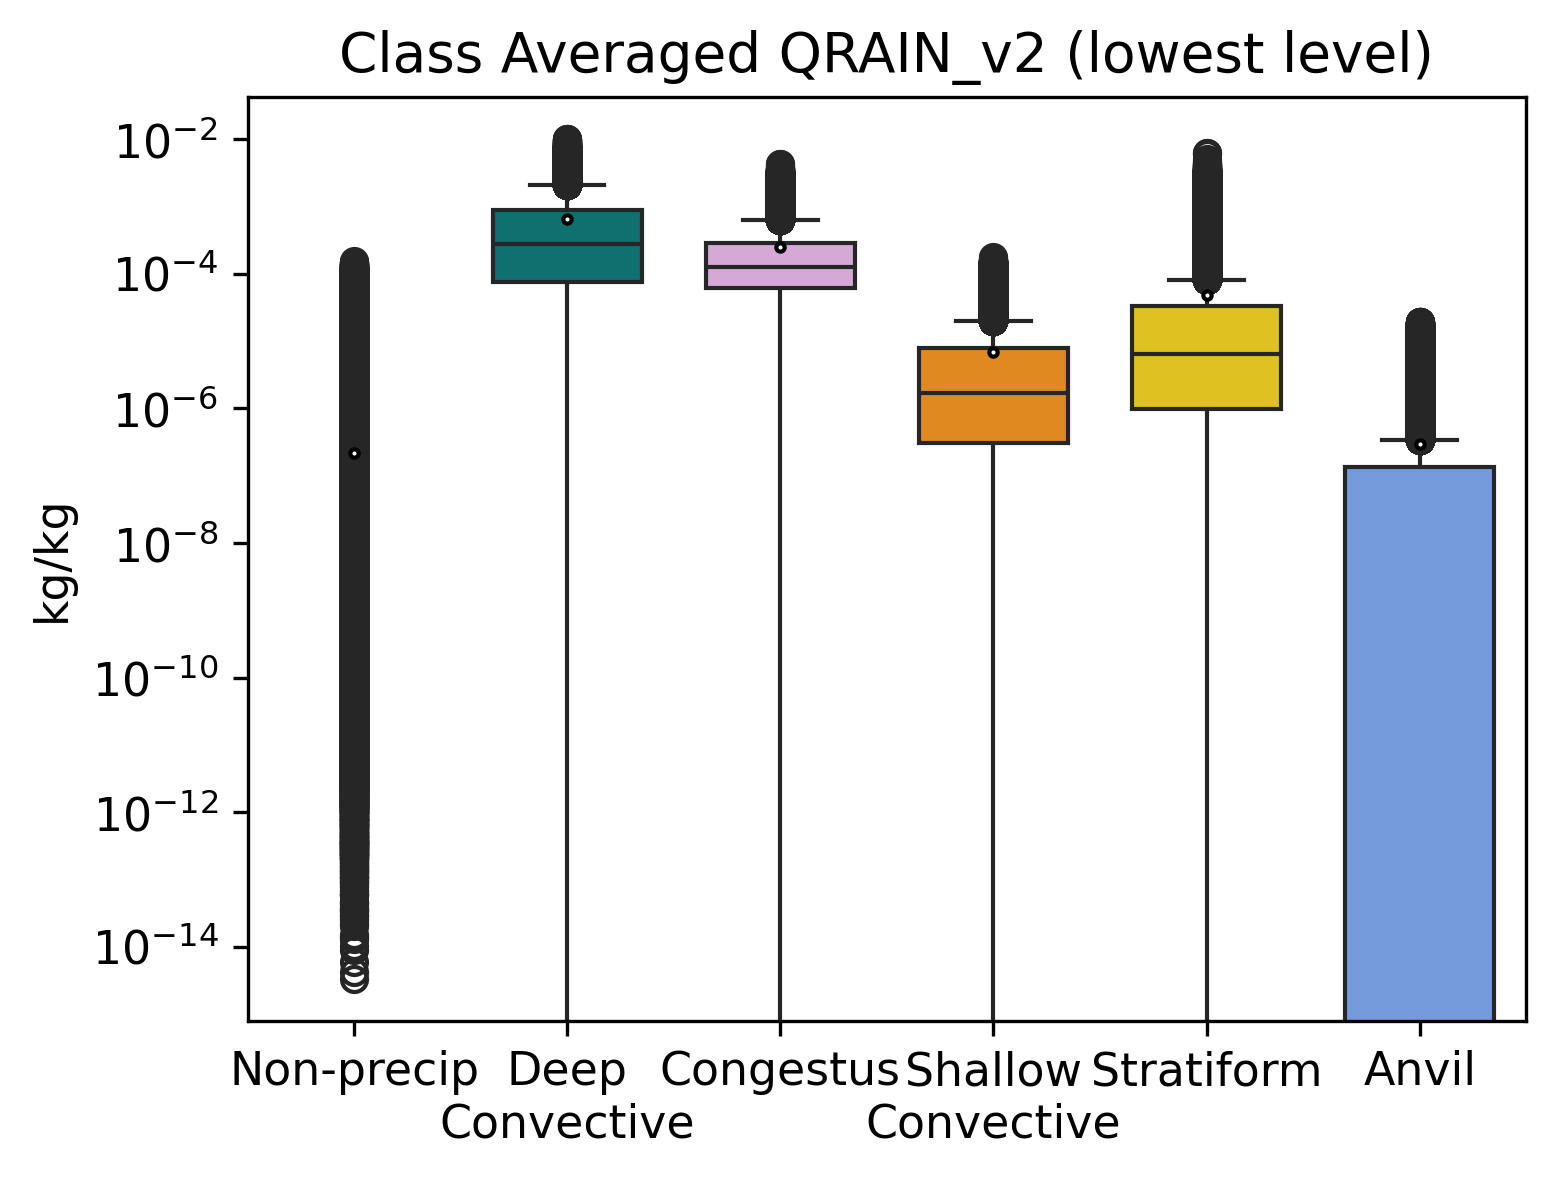

In [35]:

units = "kg/kg"
title_tag = "QRAIN_v2 (lowest level)"
create_boxplot(qrain_indexed_1hr, title_tag, units, yscale="log")

# 7hr
# title_tag = title+"7hr"
# create_boxplot(ddtq_indexed_7hr, title_tag, units)

# # 9hr
# title_tag = title+"9hr"
# create_boxplot(ddtq_indexed_9hr, title_tag, units)

/tmp/ipykernel_13967/4274265819.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(c_name)


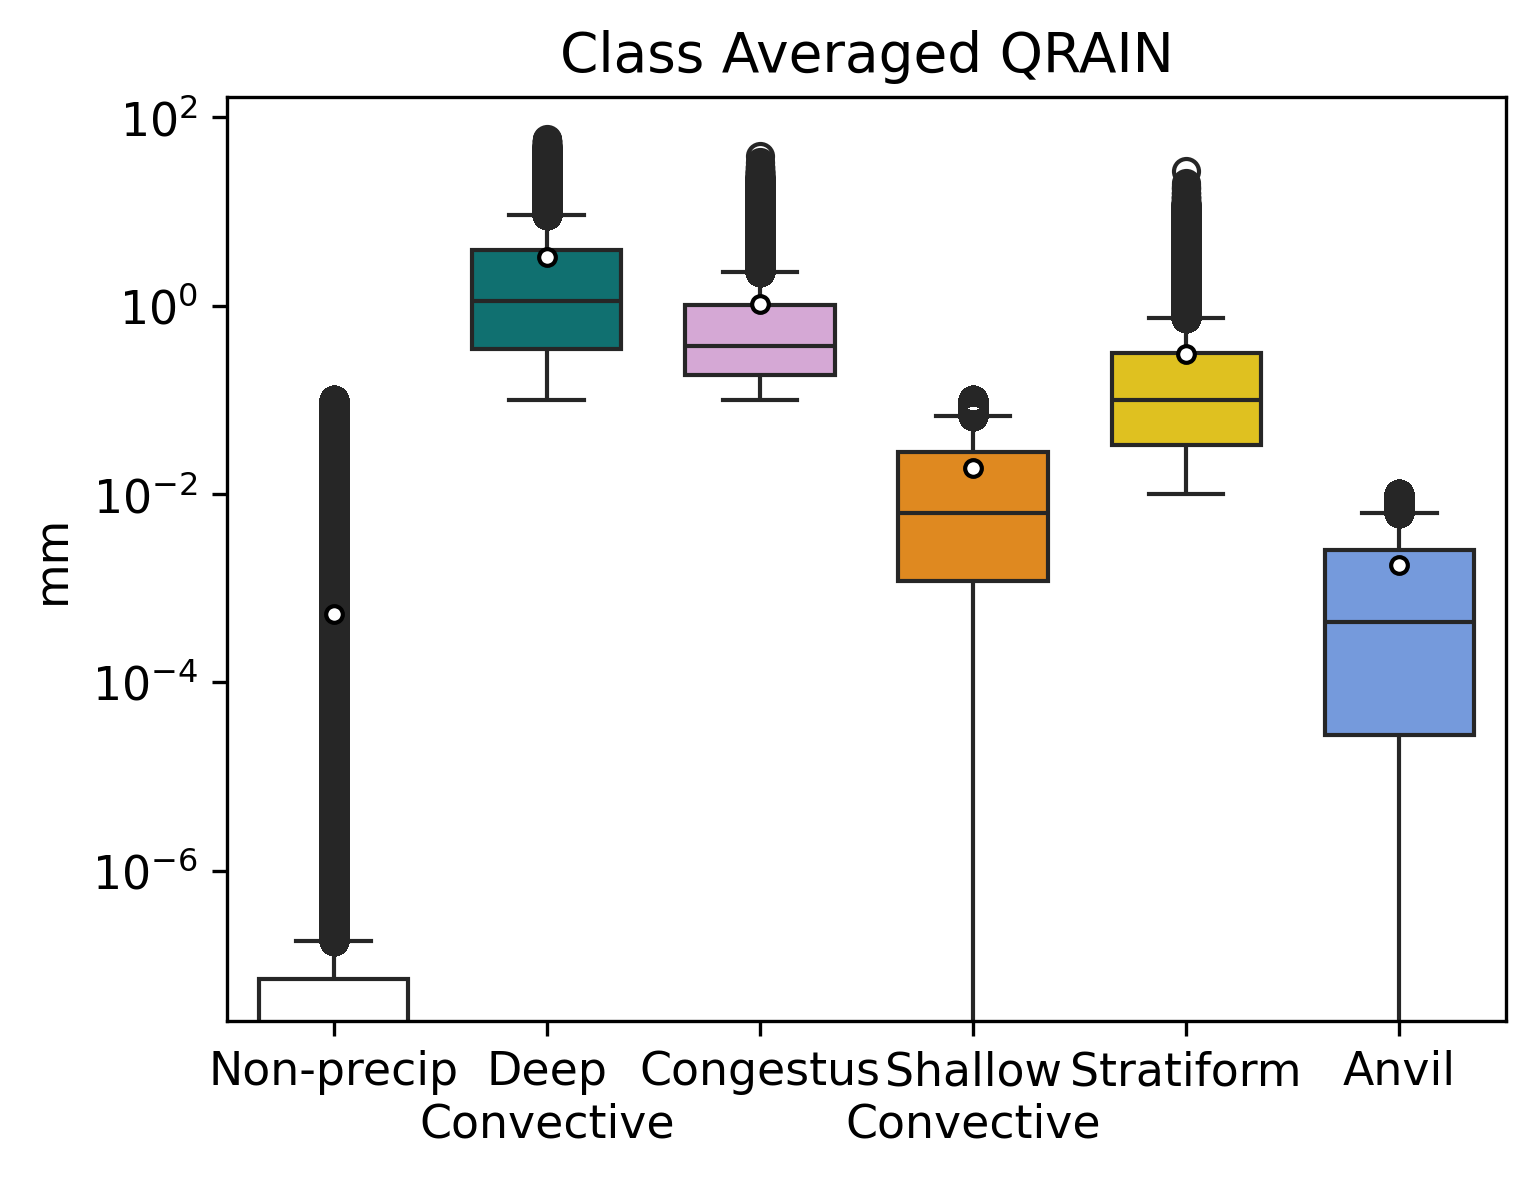

In [ ]:

units = "mm"
title_tag = "QRAIN"
create_boxplot(qrain_indexed_1hr, title_tag, units, yscale="log")

# 7hr
# title_tag = title+"7hr"
# create_boxplot(ddtq_indexed_7hr, title_tag, units)

# # 9hr
# title_tag = title+"9hr"
# create_boxplot(ddtq_indexed_9hr, title_tag, units)

/tmp/ipykernel_49580/2523534888.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(c_name)


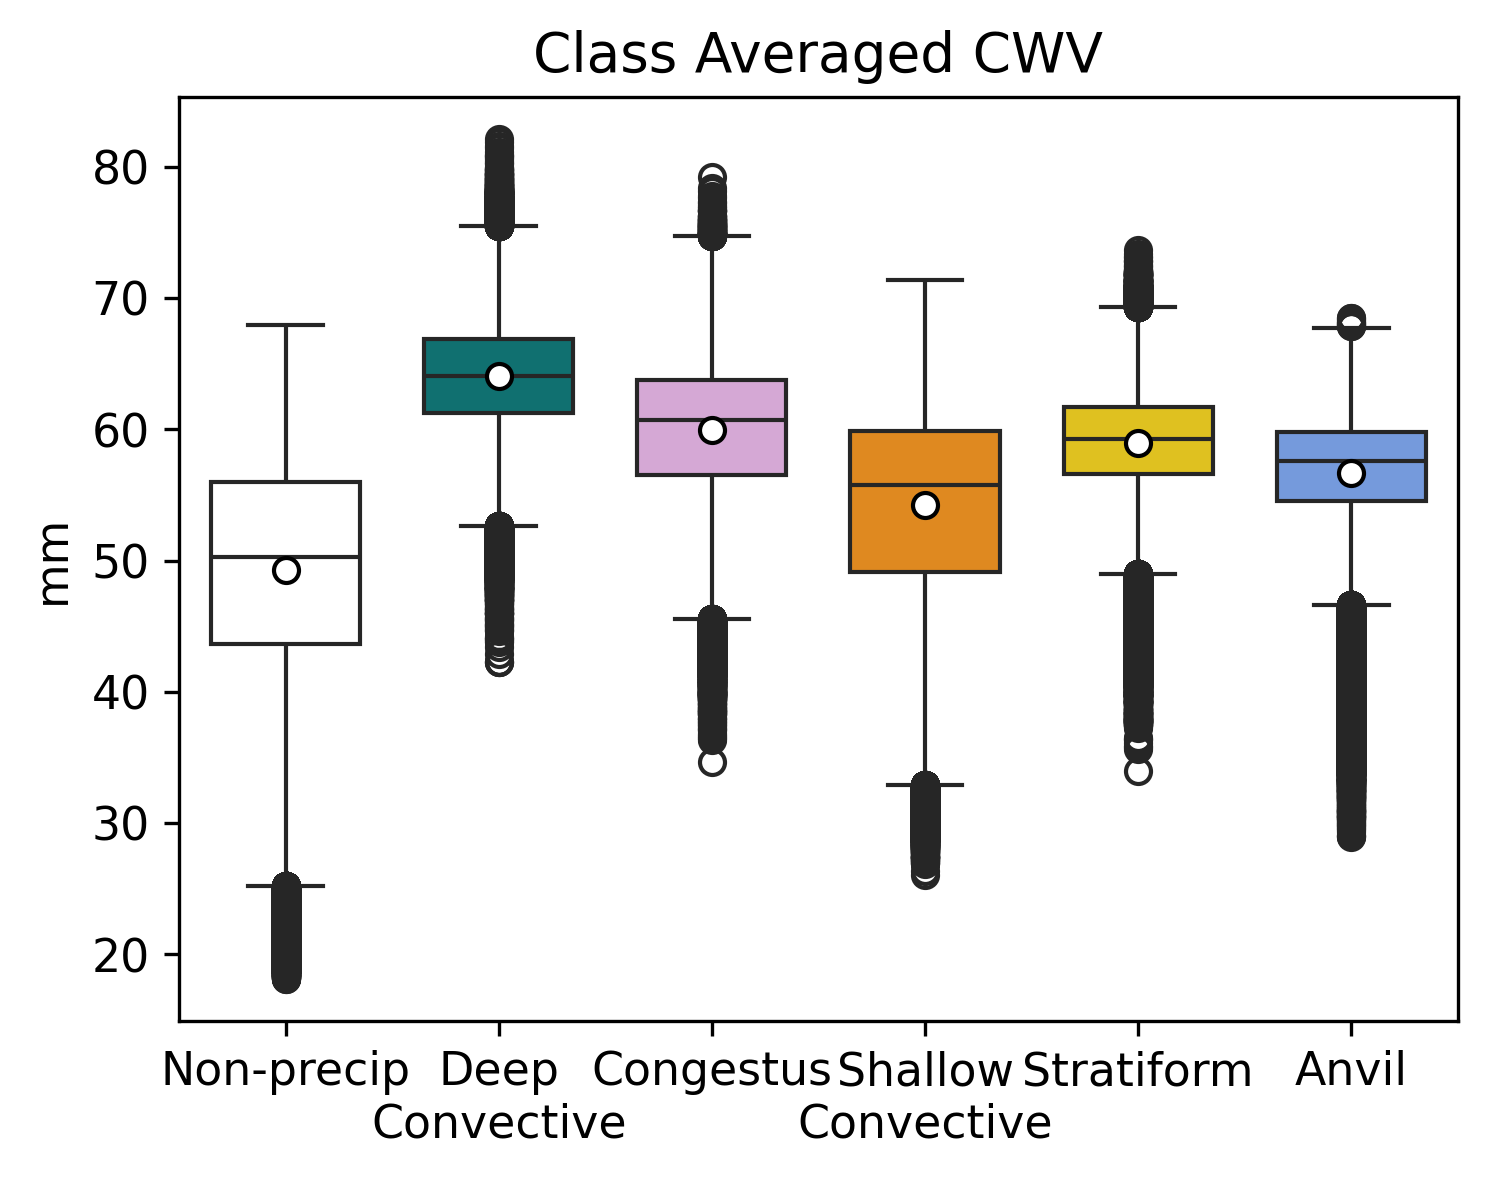

In [28]:
units = "mm"
title_tag = "CWV"
create_boxplot(cwv_indexed_1hr, title_tag, units)

/tmp/ipykernel_49580/2523534888.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(c_name)


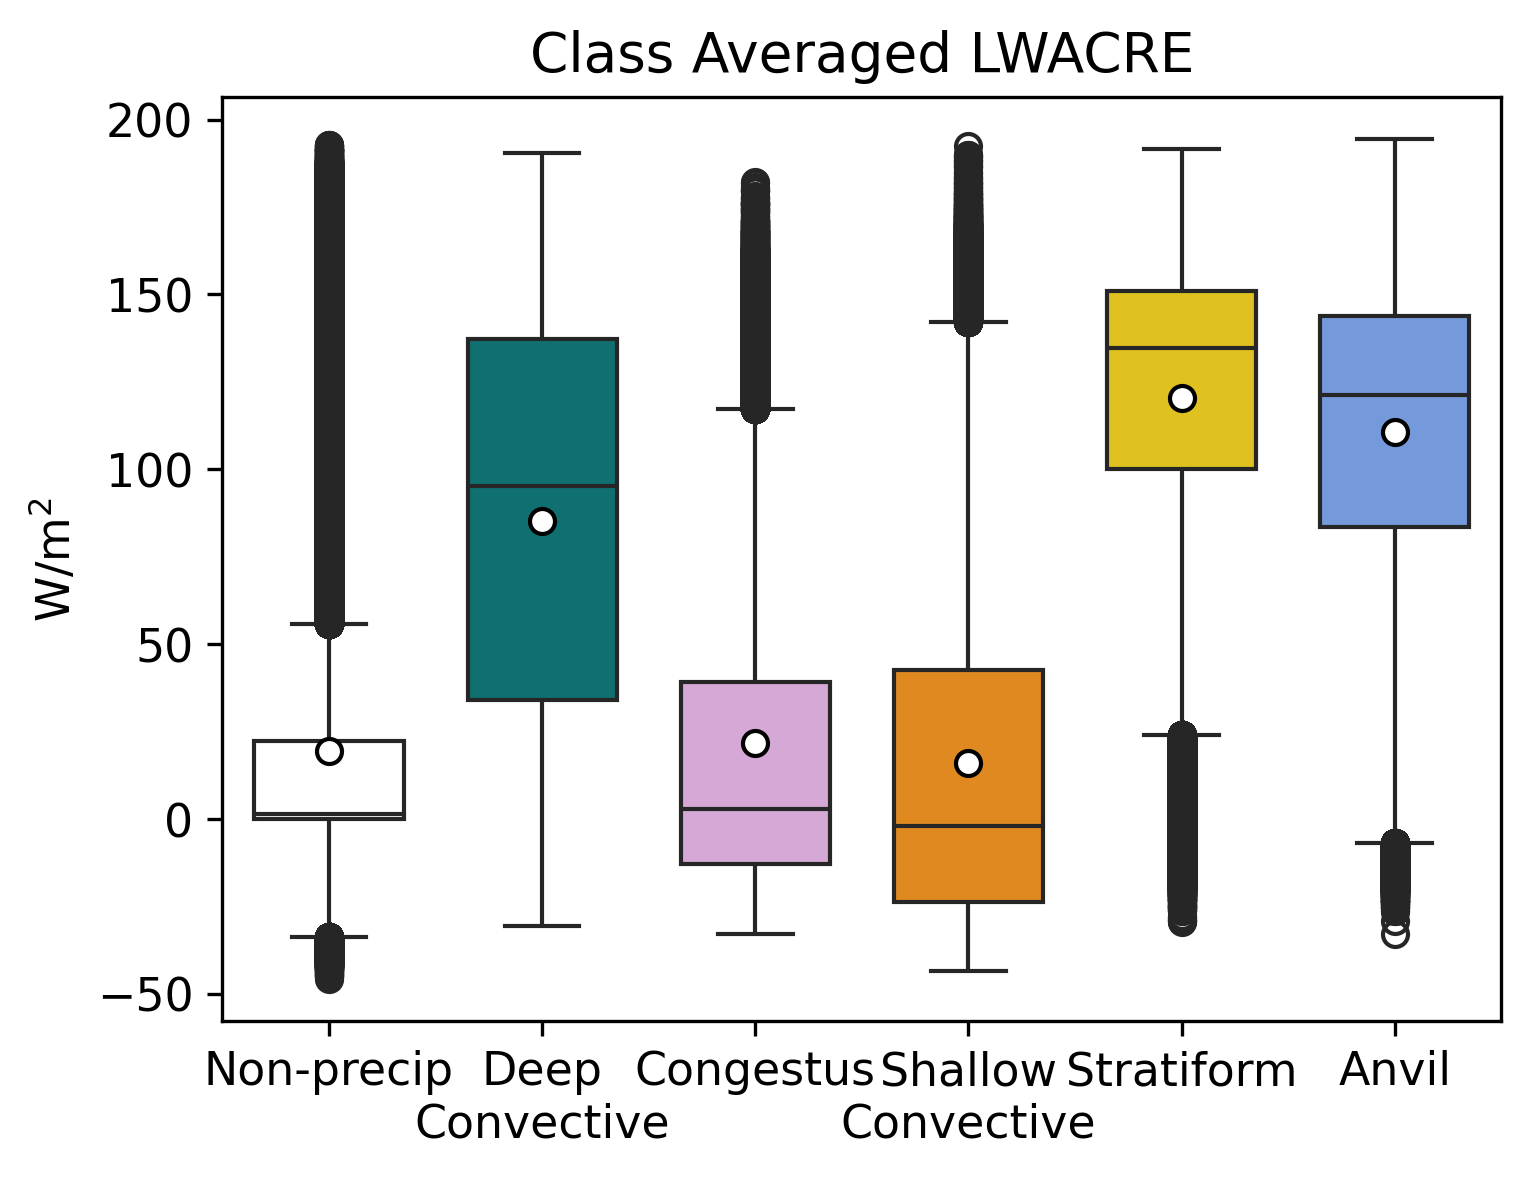

In [29]:
units = "W/m$^2$"
title_tag = "LWACRE"
create_boxplot(lwacre_indexed_1hr, title_tag, units)

/tmp/ipykernel_7331/2523534888.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(c_name)


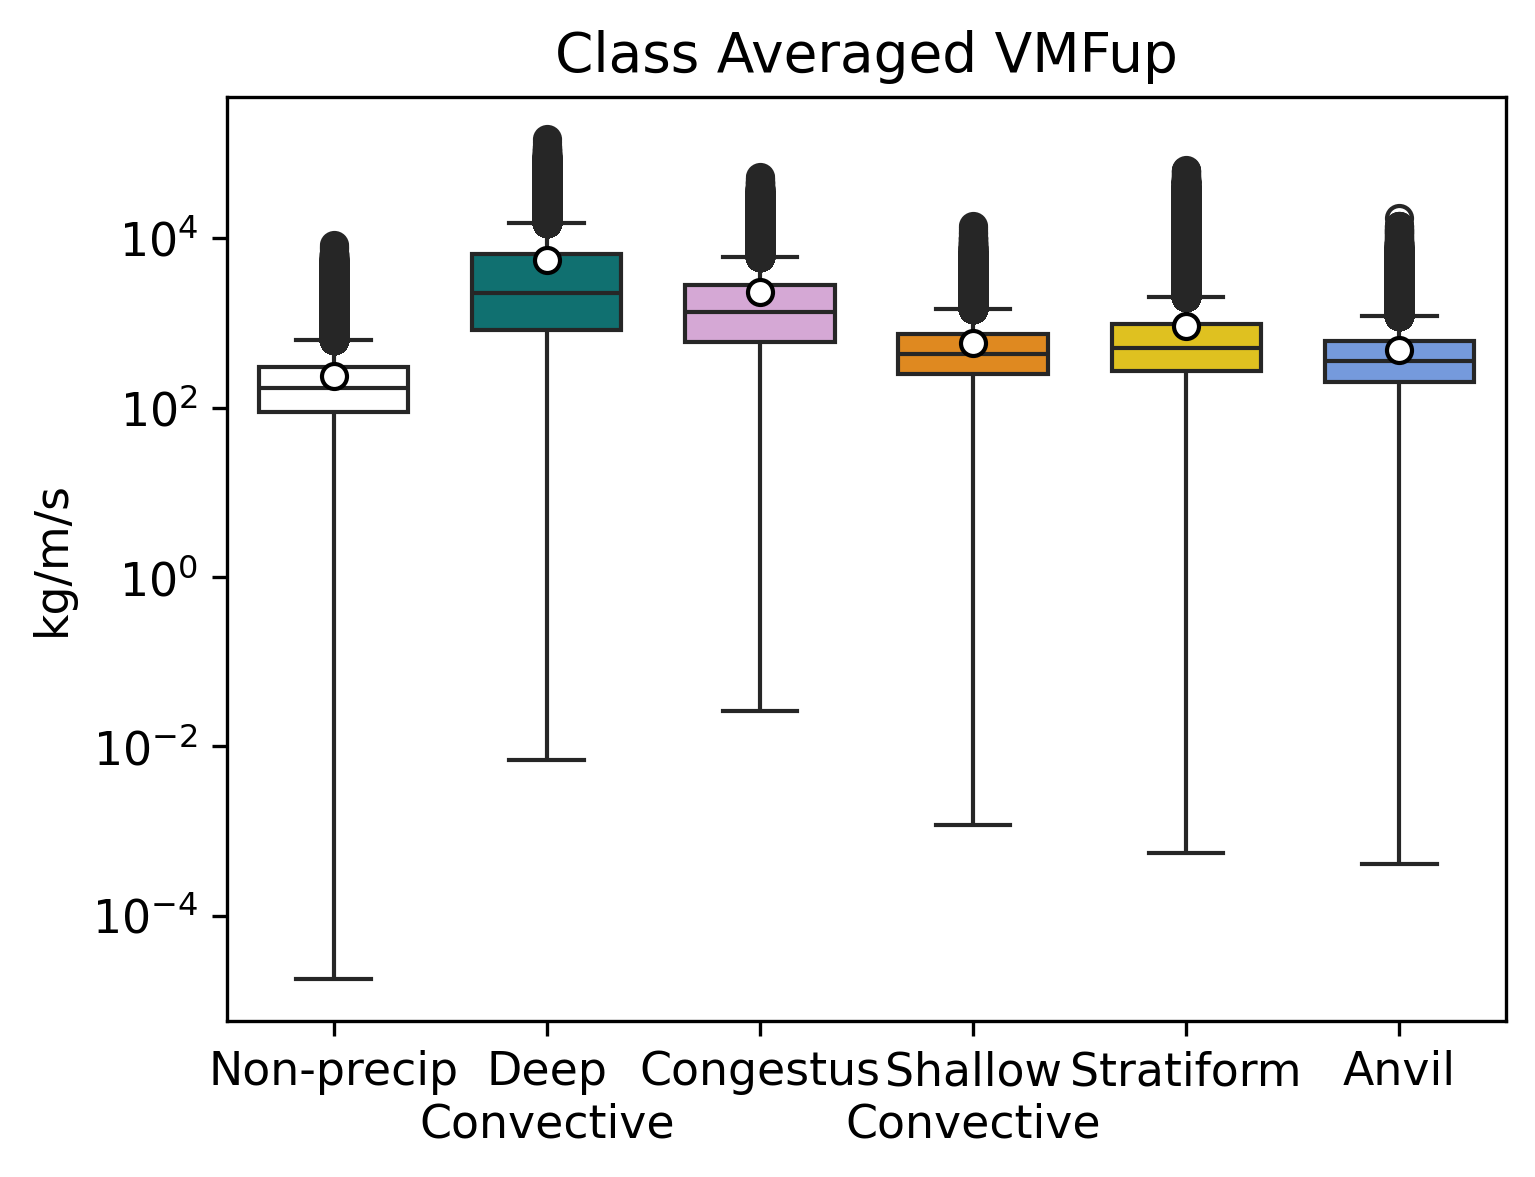

In [33]:
units = "kg/m/s"
title_tag = "VMFup"
create_boxplot(vmfu_indexed_1hr, title_tag, units, yscale='log')

/tmp/ipykernel_7331/2523534888.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(c_name)


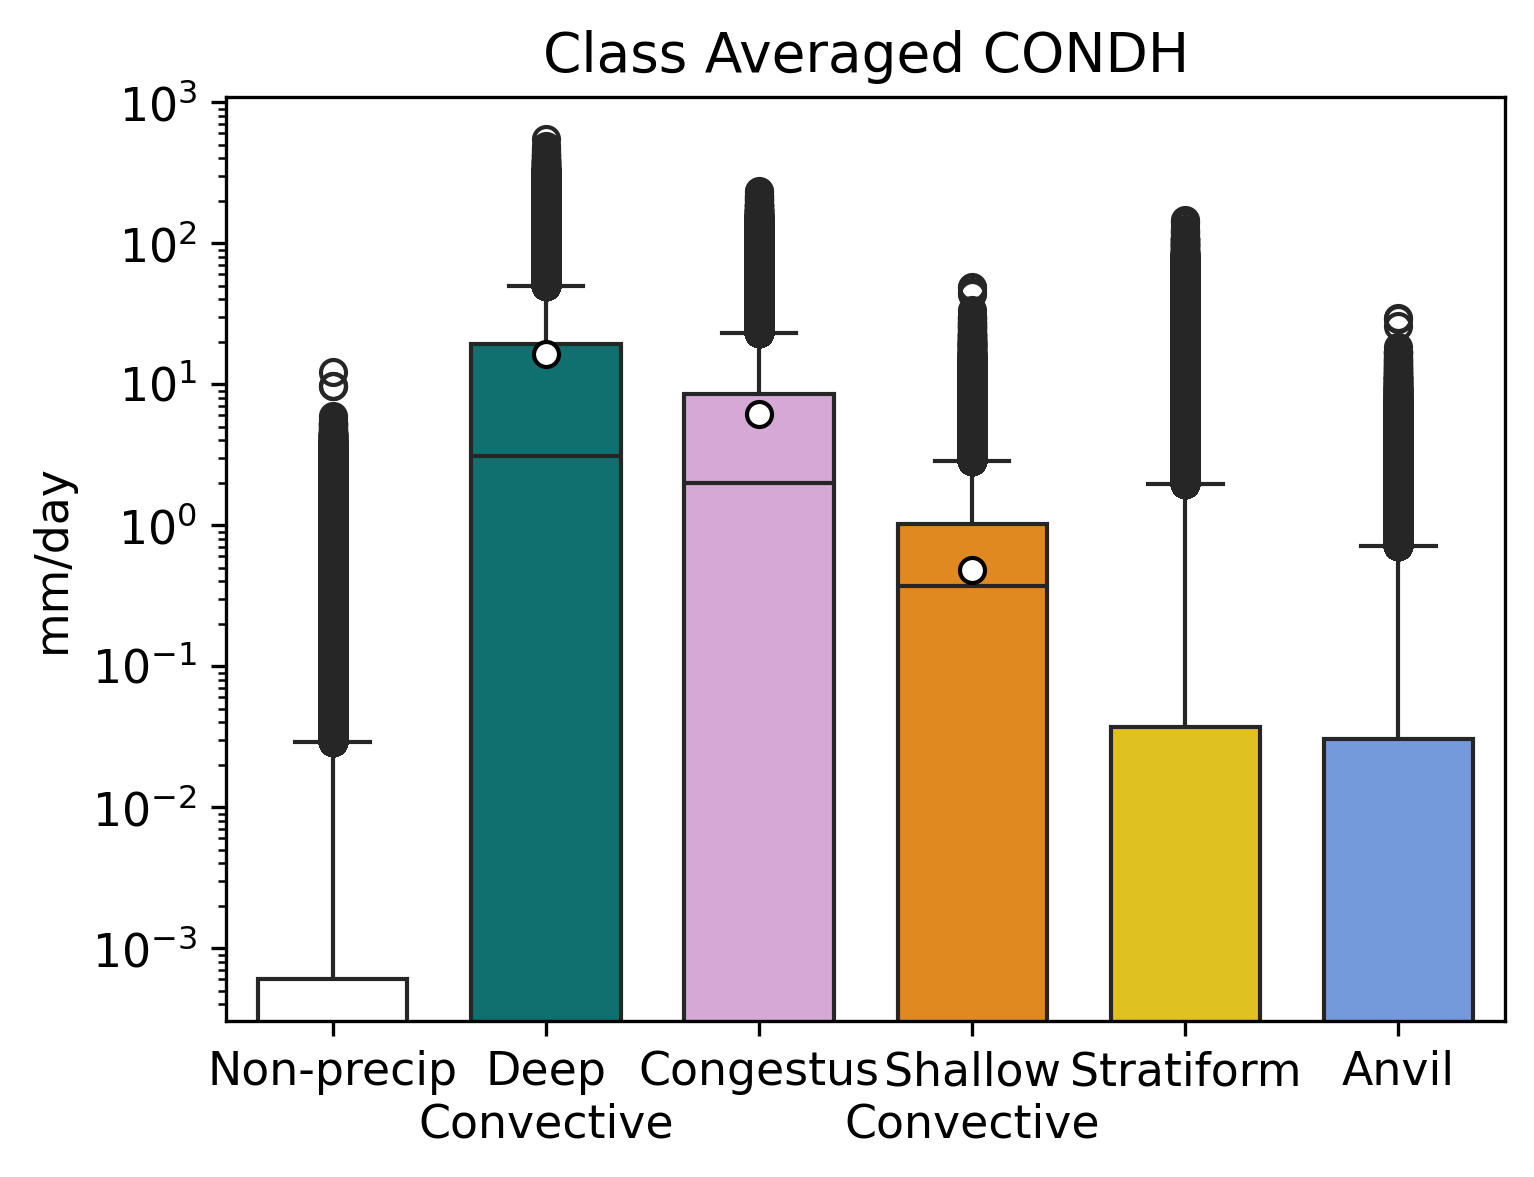

In [48]:
title_tag = "CONDH"
units = "mm/day"
create_boxplot(condh_indexed_1hr, title_tag, units, yscale='log')

In [36]:
# Global boxplot settings

def create_boxplot_noclear(invar, title_tag, units, yscale='linear'):

    # c_name = ['Non-precip', 'Deep\nConvective', 'Congestus', 'Shallow\nConvective', 'Stratiform', 'Anvil']
    # cmap = ['white', 'teal', 'plum', 'darkorange', 'gold', 'cornflowerblue']
    c_name = ['Deep\nConvective', 'Congestus', 'Shallow\nConvective', 'Stratiform', 'Anvil']
    cmap = ['teal', 'plum', 'darkorange', 'gold', 'cornflowerblue']
    sns.set_palette(cmap)

    fig = plt.figure(figsize=(5.5,4),dpi=300)
    # fig.set_facecolor('white')
    ax = fig.subplots(nrows=1, ncols=1)
    # sns.boxplot([invar[0], invar[1], invar[2], invar[3], invar[4], invar[5]],
    sns.boxplot([invar[1], invar[2], invar[3], invar[4], invar[5]],
                width=0.7, showmeans=True, #log_scale=log_scale,
                meanprops={"marker":"o", "markerfacecolor":"white", 
                "markeredgecolor":"black", "markersize":2})

    ax.set_yscale(yscale)
    # ax.set_ylim([1e-2,1e14])
    ax.set_xticklabels(c_name)
    plt.ylabel(units)#, weight='bold')
    plt.title("Class Averaged "+title_tag)#, weight='bold')

/tmp/ipykernel_49580/4007717641.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(c_name)


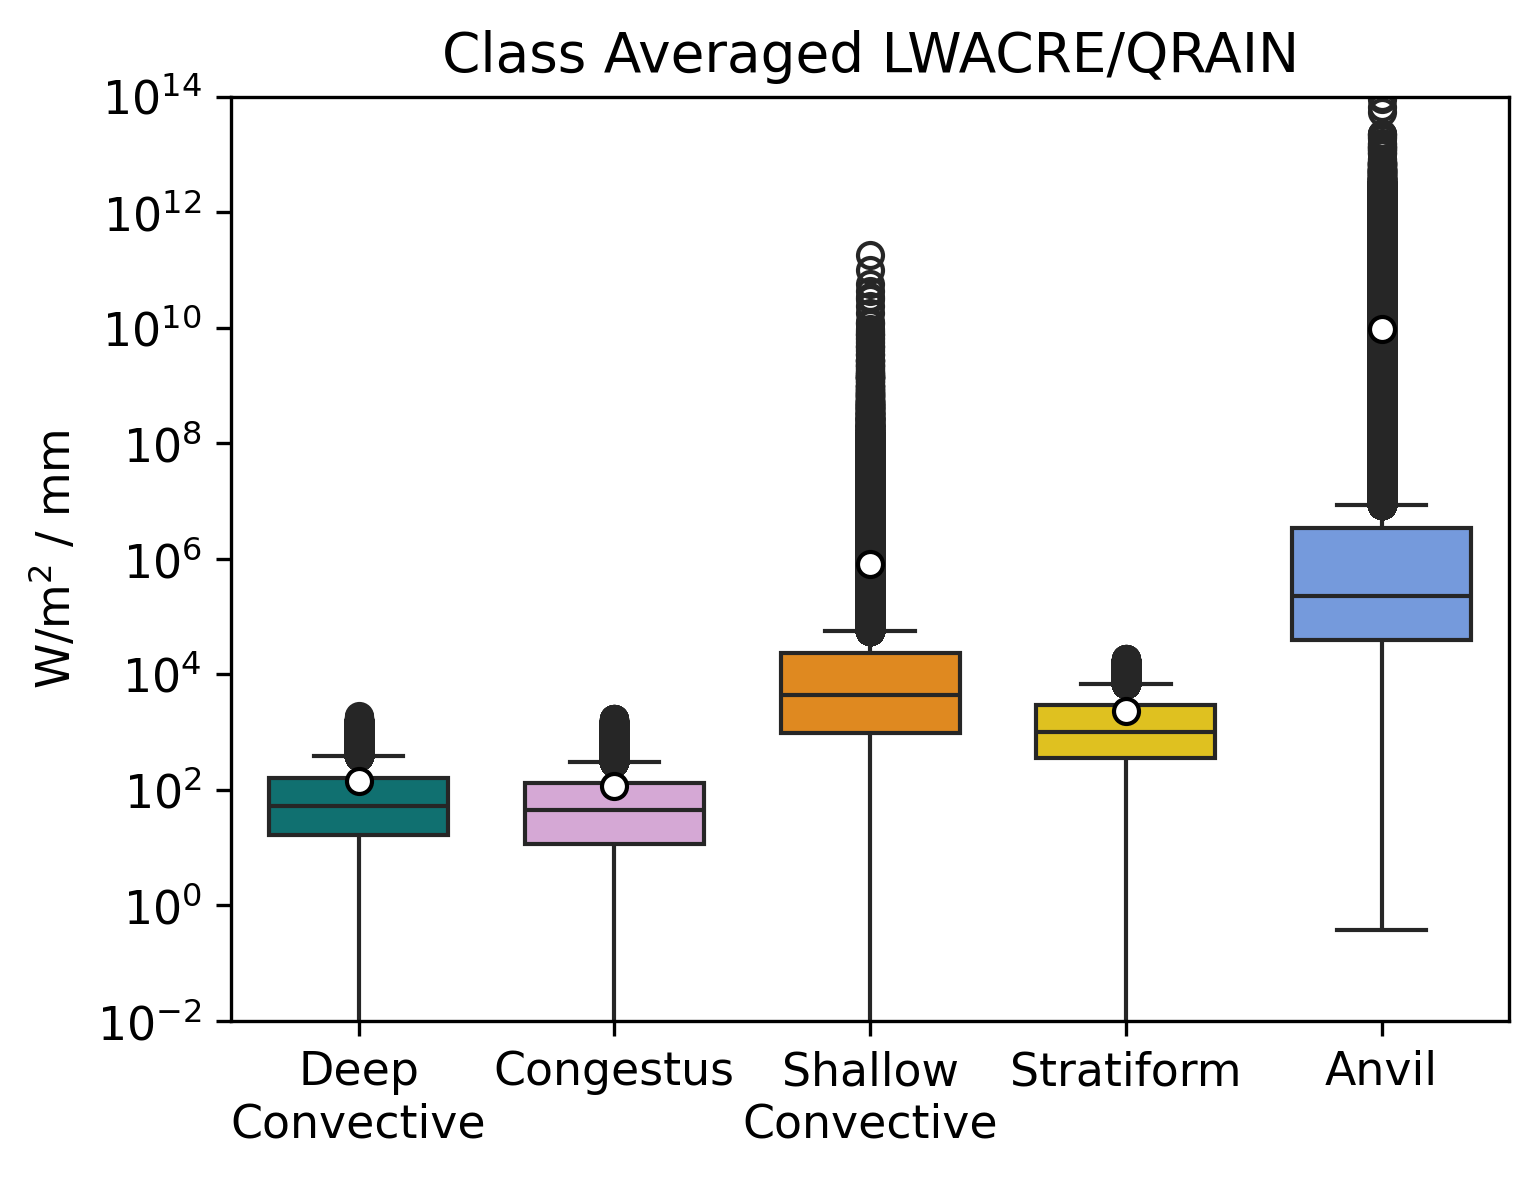

In [56]:
# Local LW Feedback
units = "W/m$^2$ / mm"
title_tag = "LWACRE/QRAIN"
create_boxplot_noclear(lwfeedb1_indexed_1hr, title_tag, units, yscale="log")

/tmp/ipykernel_7331/4010515275.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(c_name)


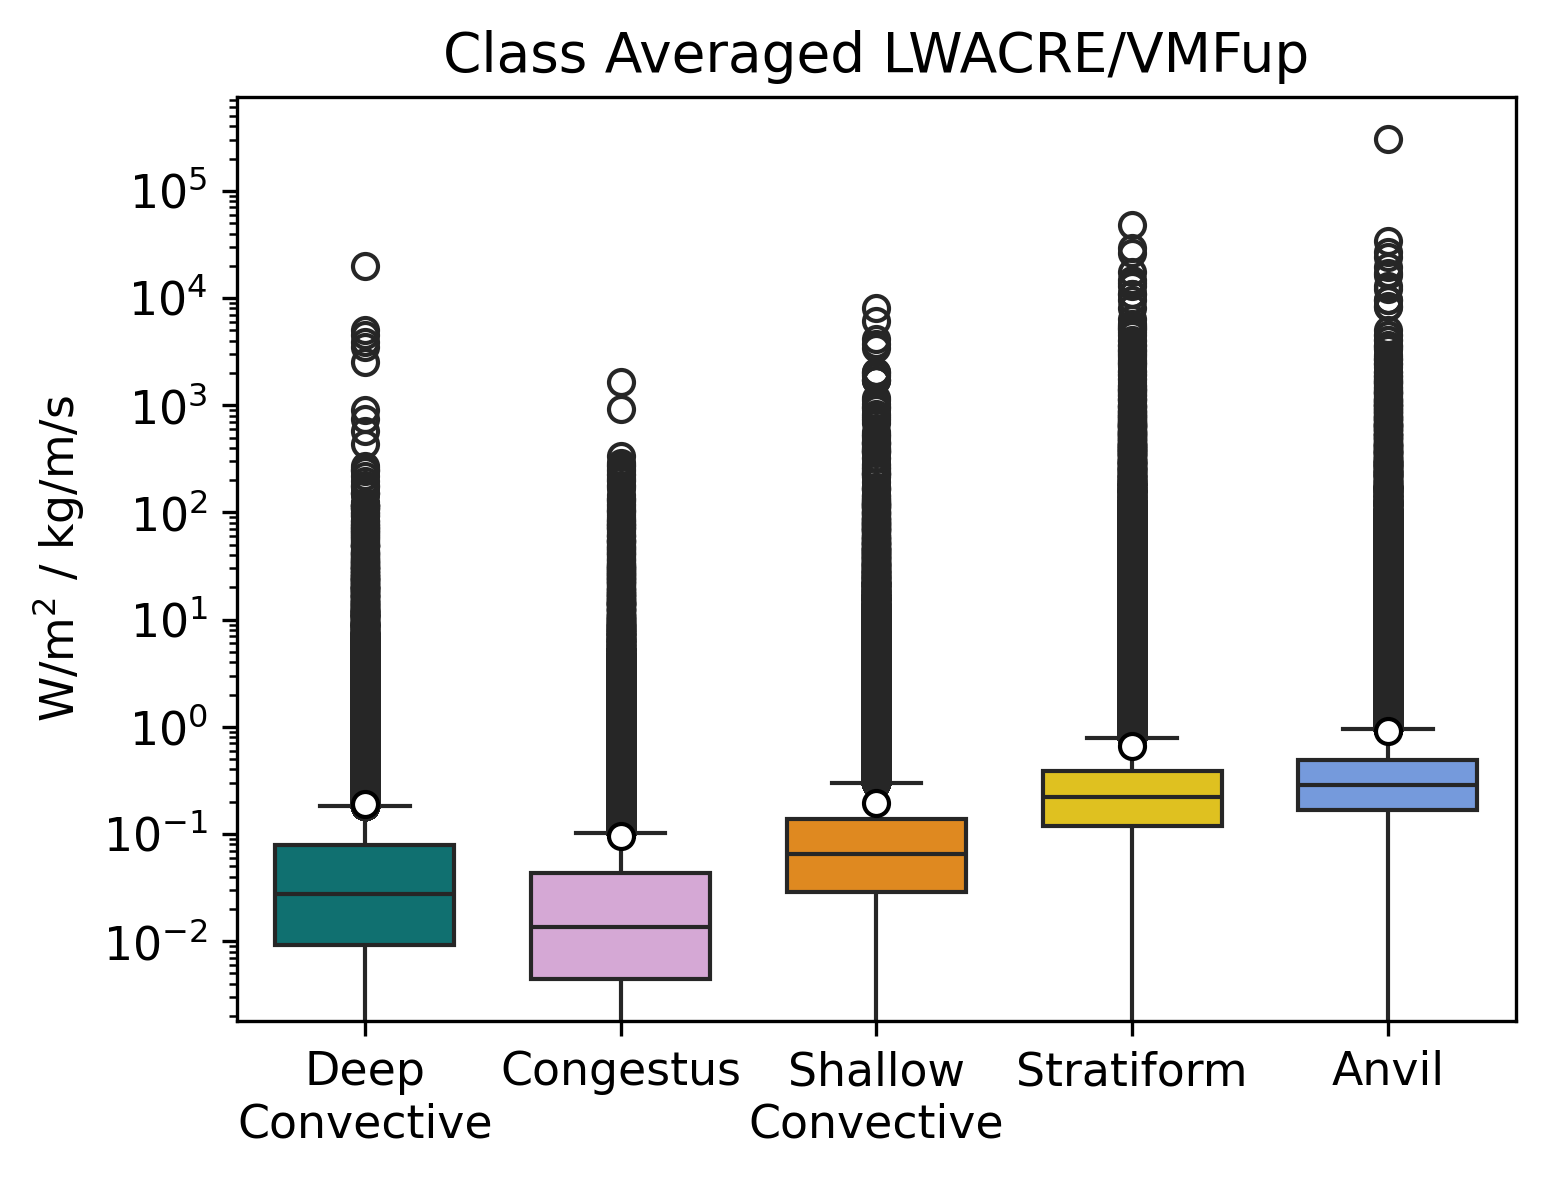

In [37]:
# Local LW Feedback
units = "W/m$^2$ / kg/m/s"
title_tag = "LWACRE/VMFup"
create_boxplot_noclear(lwfeedb2_indexed_1hr, title_tag, units, yscale="log")

/tmp/ipykernel_13967/3716787391.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(c_name)


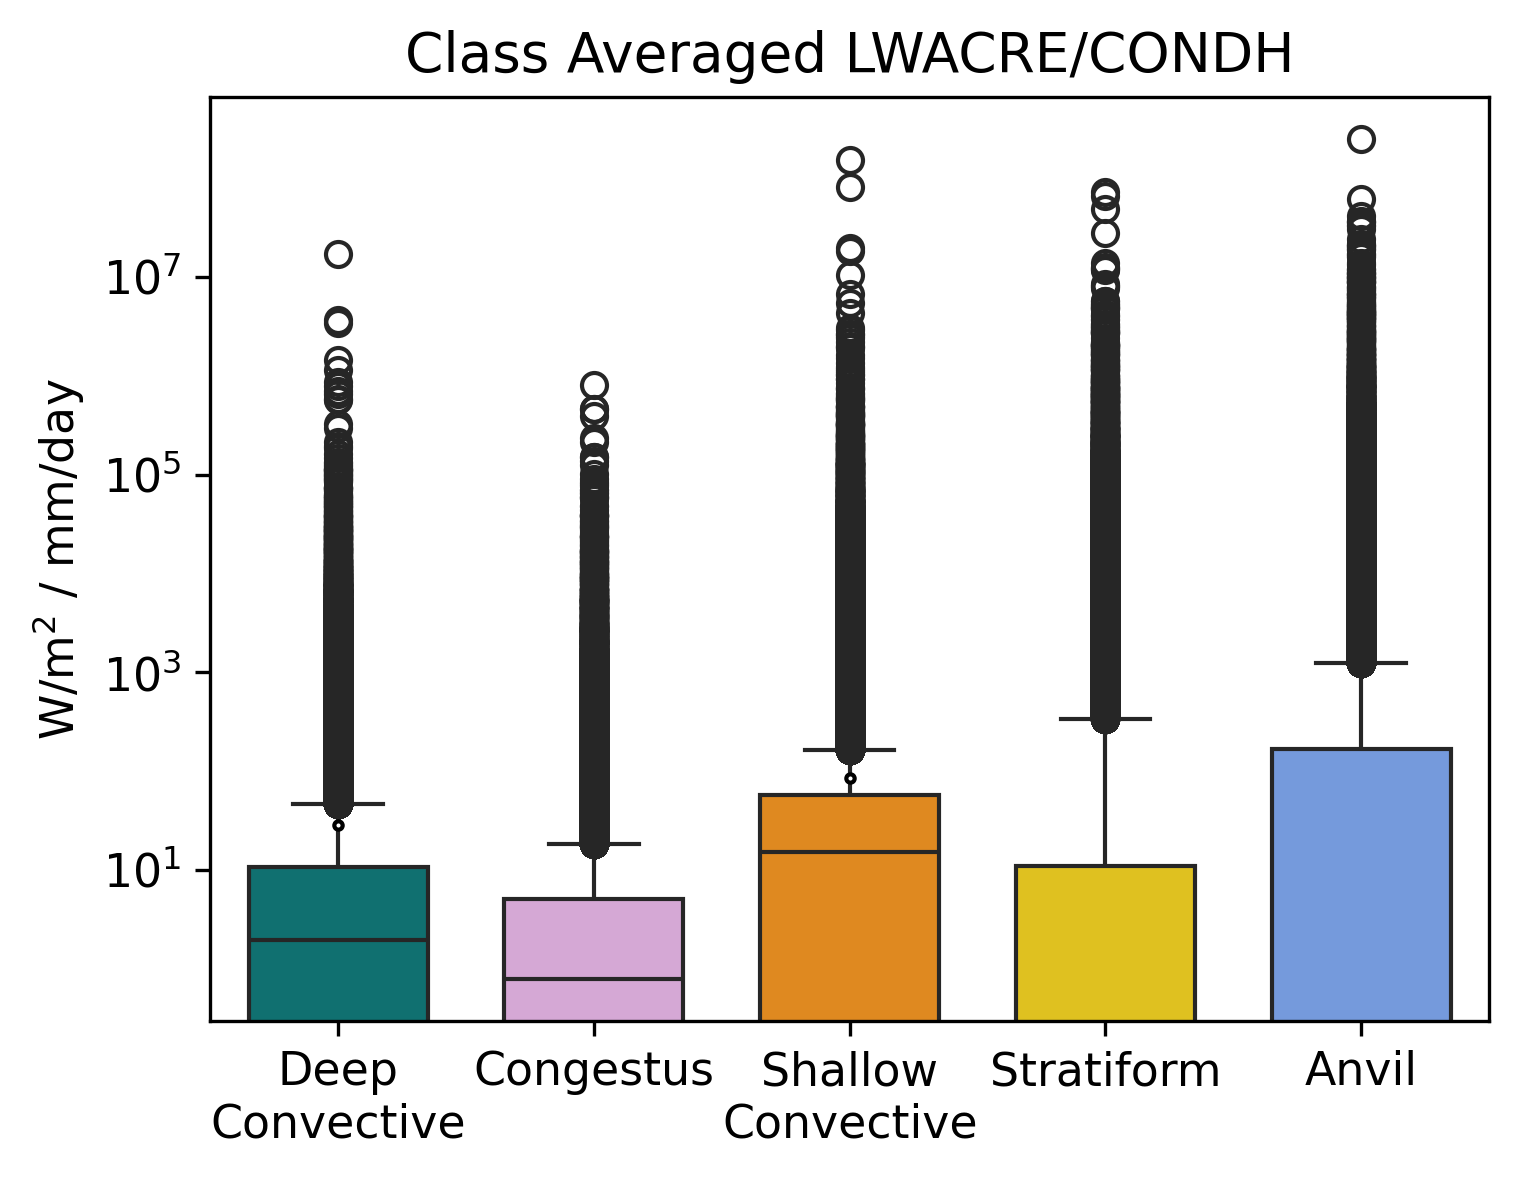

In [37]:
# Local LW Feedback
units = "W/m$^2$ / mm/day"
title_tag = "LWACRE/CONDH"
create_boxplot_noclear(lwfeedb3_indexed_1hr, title_tag, units, yscale="log")